In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy import stats

nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
error_of_the_mean = lambda x: nmad(x)/np.sqrt(len(x))

def binned_median(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_error

In [10]:
import statsmodels.api as sm

def rlm_fit1d(x, y, t=1.5, order=1):
    '''
    1D robust polynomial fit.
    
    Given x array and y array, calculate the 1D robust 
    polynomial fit of arbitrary order. Huber weight
    function is used. 
    
    See also poly_val1d.py
    
    INPUT:
    1D arrays of x and y values; tunning parameter t; 
    order of the polynomial fit.
    
    OUTPUT:
    Array of parameters of the polynomial [a0, a1, a2 ...] 
    so that y = a0 + a1*x + a2*x**2 + ...
    '''
    
    ncols = order+1
    a = np.zeros((x.size,ncols))
    for i in range(order+1):
        a[:,i] = x**i
    res = sm.RLM(y, a, M=sm.robust.norms.HuberT(t=t)).fit()
    m = res.params
    return(m)

In [4]:
sweep_list = ['sweep-140p010-150p015.fits', 'sweep-150p010-160p015.fits',
              'sweep-160p010-170p015.fits', 'sweep-170p010-180p015.fits', 
              'sweep-180p010-190p015.fits', 'sweep-190p010-200p015.fits']

cat = []
for sweep_fn in sweep_list:
    tmp = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/'+sweep_fn, columns=['GAIA_PHOT_G_MEAN_MAG'])
    mask = (tmp['GAIA_PHOT_G_MEAN_MAG']>16) & (tmp['GAIA_PHOT_G_MEAN_MAG']<18)
    idx = np.where(mask)[0]
    tmp = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/'+sweep_fn, rows=idx)
    tmp = Table(tmp)
    cat.append(tmp)
    
cat = vstack(cat)
print(len(cat))

141912


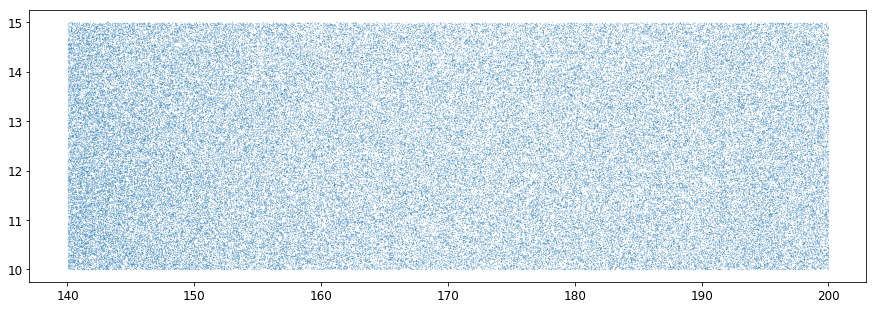

0.865860533288
0.864556908507
0.857968318394
0.855755679576
121442


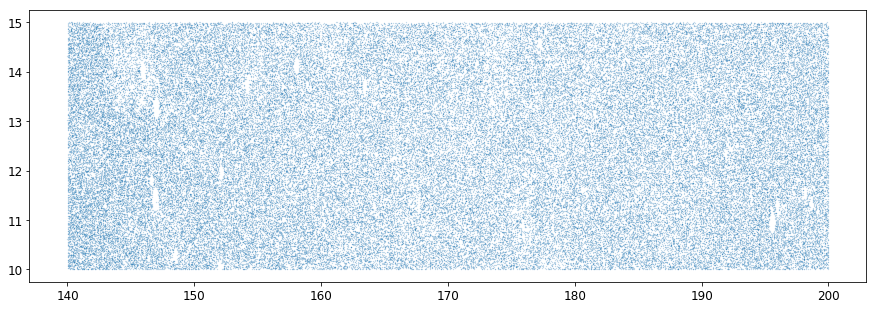

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

mask = (cat['MASKBITS']==0)
print(np.sum(mask)/len(mask))
mask &= cat['TYPE']=='PSF '
print(np.sum(mask)/len(mask))
mask &= cat['FRACFLUX_R']<0.1
print(np.sum(mask)/len(mask))
mask &= np.isfinite(cat['GAIA_PHOT_BP_MEAN_MAG']) & np.isfinite(cat['GAIA_PHOT_RP_MEAN_MAG'])
print(np.sum(mask)/len(mask))
print(np.sum(mask))
cat = cat[mask]

plt.figure(figsize=(15, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1'])
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2'])
    
print(band, cat[band+'mag'].min(), cat[band+'mag'].max())

g 15.8301 21.1147
r 15.7185 19.2553
z 14.5773 18.8999


In [7]:
# Arjun's Gaia-to-DECam transformations.
coeffs = dict(
    g=[-0.11368, 0.37504, 0.17344, -0.08107, 0.28088,
       -0.21250, 0.05773,-0.00525],
    r=[ 0.10533,-0.22975, 0.06257,-0.24142, 0.24441,
        -0.07248, 0.00676],
    z=[ 0.46744,-0.95143, 0.19729,-0.08810, 0.01566])

gaia_plot_old = Table()
gaia_plot_old['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['z']
for i, b in enumerate(bands):
    mag = np.zeros(len(gaia_plot_old))
    for order, c in enumerate(coeffs[b]):
        mag += c * gaia_plot_old['BP_RP']**order
    gaia_plot_old['ls_'+b] = mag

In [32]:
# coeffs = dict(
#     g = [-0.1178631039, 0.3650113495, 0.5608615360, -0.2850687702,
#         -1.0243473939, 1.4378375491, 0.0679401731, -1.1713172509,
#         0.9107811975, -0.3374324004, 0.0683946390, -0.0073089582,
#         0.0003230170],
#     r = [0.1139078673, -0.2868955307, 0.0013196434, 0.1029151074,
#         0.1196710702, -0.3729031390, 0.1859874242, 0.1370162451,
#         -0.1808580848, 0.0803219195, -0.0180218196, 0.0020584707,
#         -0.0000953486],
#     z = [0.4811198057, -0.9990015041, 0.1403990019, 0.2150988888,
#         -0.2917655866, 0.1326831887, -0.0259205004, 0.0018548776])

__Supplement with bluest and reddest stars__

In [8]:
extreme = Table.read('/global/cscratch1/sd/rongpu/dr8/misc/dr8_south_gaia_reddest_and_bluest.fits')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    extreme['gmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_G'])
    extreme['rmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_R'])
    extreme['zmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_Z'])
    extreme['w1mag'] = 22.5 - 2.5*np.log10(extreme['FLUX_W1'])
    extreme['w2mag'] = 22.5 - 2.5*np.log10(extreme['FLUX_W2'])

__New polynomial fits__

In [86]:
coeffs_new = {}
band = 'z'

mask = np.ones(len(cat), dtype=bool)
mask1 = (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']>3.1)

x = np.concatenate([(cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1]])
y = np.concatenate([(cat[band+'mag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], (extreme[band+'mag']-extreme['GAIA_PHOT_G_MEAN_MAG'])[mask1]])
poly_order = 7
coeffs_new[band] = rlm_fit1d(x, y, t=0.1, order=poly_order)
# coeffs_new[band] = np.polyfit(x, y, deg=2)
print(band)
print(coeffs_new[band])

z
[0.4811198057 -0.9990015041 0.1403990019 0.2150988888 -0.2917655866
 0.1326831887 -0.0259205004 0.0018548776]


In [87]:
coeffs_new[band] = np.round(coeffs_new[band], decimals=10)
print(coeffs_new[band])

[0.4811198057 -0.9990015041 0.1403990019 0.2150988888 -0.2917655866
 0.1326831887 -0.0259205004 0.0018548776]


In [88]:
gaia_plot = Table()
gaia_plot['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['z']
for i, b in enumerate(bands):
    mag = np.zeros(len(gaia_plot))
    for order, c in enumerate(coeffs_new[b]):
        mag += c * gaia_plot['BP_RP']**order
    gaia_plot['ls_'+b] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(cat['GAIA_PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new[b]):
        mag += c * (cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])**order
    cat[b+'mag_predict'] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(extreme['GAIA_PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new[b]):
        mag += c * (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])**order
    extreme[b+'mag_predict'] = mag

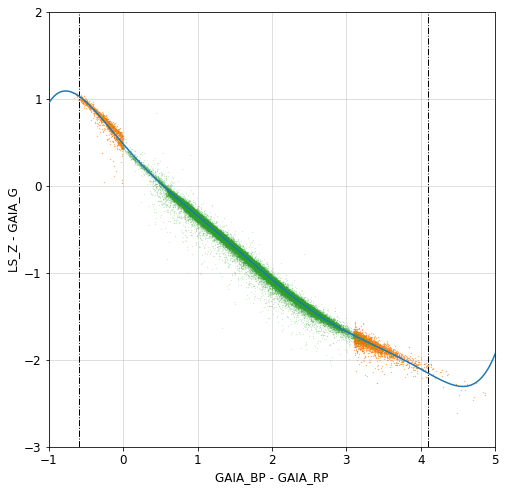

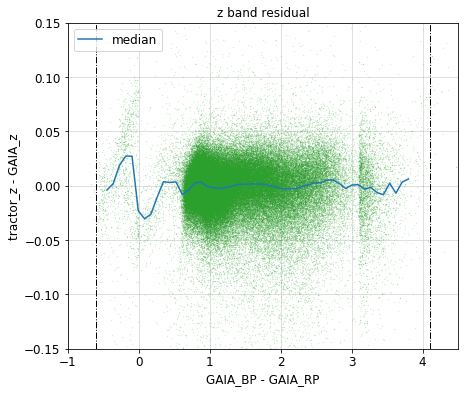

In [89]:
bprp_min, bprp_max = -0.6, 4.1

mask = np.ones(len(cat), dtype=bool)
mask1 = (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']>3.1)

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1], (extreme['zmag']-extreme['GAIA_PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
# plt.plot((gaia_plot_old['BP_RP']), (gaia_plot_old['ls_z']), '-', label='old transformation', zorder=3, c='C3', ls='--', lw=1)
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_z']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_Z - GAIA_G')
plt.axis([-1., 5., -3, 2.])
# plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('plots/decals_z.png')
plt.show()

x = np.concatenate([(cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1]])
y_tractor = np.concatenate([(cat[band+'mag'])[mask], (extreme[band+'mag'])[mask1]])
y_predict = np.concatenate([(cat[band+'mag_predict'])[mask], (extreme[band+'mag_predict'])[mask1]])

bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)

plt.figure(figsize=(7, 6))
plt.plot(x, y_tractor-y_predict, 'C2.', ms=0.3, alpha=0.5, zorder=2)
plt.plot(bin_center, bin_median, label='median')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('tractor_{0} - GAIA_{0}'.format(band))
plt.title('{} band residual'.format(band))
plt.axis([-1., 4.5, -0.15, 0.15])
plt.grid(alpha=0.5)
plt.legend(markerscale=10, loc='upper left')
plt.savefig('plots/decals_{}_residual.png'.format(band))
plt.show()

--------

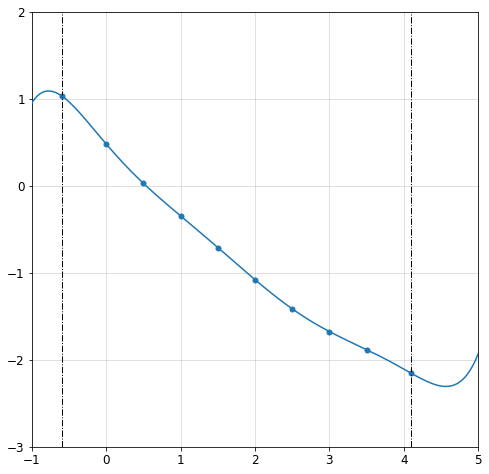

In [51]:
b = 'z'
bprp_list = np.array([-0.6, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.1])
mag_list = np.zeros(len(bprp_list))
for order, c in enumerate(coeffs_new[b]):
    mag_list += c * (bprp_list)**order
    
plt.figure(figsize=(8, 8))
plt.plot(bprp_list, mag_list, '.', ms=10)
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_z']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.axis([-1., 5., -3, 2.])
plt.grid(alpha=0.5)
plt.show()

In [76]:
coeffs_new1 = {}
x = bprp_list
y = mag_list
poly_order = 7
coeffs_new1[band] = rlm_fit1d(x, y, t=1, order=poly_order)
# coeffs_new[band] = np.polyfit(x, y, deg=2)
print(band)
print(coeffs_new1[band])
    
coeffs_new1[band] = np.round(coeffs_new1[band], decimals=6)
print(coeffs_new1[band])

z
[0.4811198057 -0.9990015041 0.1403990019 0.2150988888 -0.2917655866
 0.1326831887 -0.0259205004 0.0018548776]
[0.4811200000 -0.9990020000 0.1403990000 0.2150990000 -0.2917660000
 0.1326830000 -0.0259210000 0.0018550000]


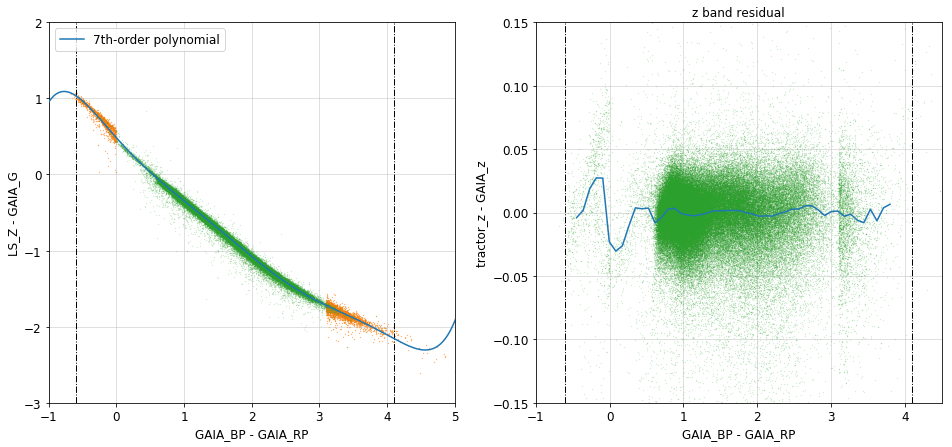

In [102]:
cat1 = cat.copy()
extreme1 = extreme.copy()

gaia_plot1 = Table()
gaia_plot1['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['z']
for i, b in enumerate(bands):
    mag = np.zeros(len(gaia_plot1))
    for order, c in enumerate(coeffs_new1[b]):
        mag += c * gaia_plot1['BP_RP']**order
    gaia_plot1['ls_'+b] = mag

for i, b in enumerate(bands):
    mag = np.copy(cat1['GAIA_PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new1[b]):
        mag += c * (cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])**order
    cat1[b+'mag_predict'] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(extreme1['GAIA_PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new1[b]):
        mag += c * (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])**order
    extreme1[b+'mag_predict'] = mag
    
bprp_min, bprp_max = -0.6, 4.1

mask = np.ones(len(cat1), dtype=bool)
mask1 = (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG']>3.1)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot((cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat1['zmag']-cat1['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
ax[0].plot((extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])[mask1], (extreme1['zmag']-extreme1['GAIA_PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
ax[0].plot((gaia_plot1['BP_RP']), (gaia_plot1['ls_z']), '-', label='{}th-order polynomial'.format(poly_order), zorder=3, c='C0')
ax[0].axvline(bprp_min, lw=1, ls='-.', color='k')
ax[0].axvline(bprp_max, lw=1, ls='-.', color='k')
ax[0].set_xlabel('GAIA_BP - GAIA_RP')
ax[0].set_ylabel('LS_Z - GAIA_G')
ax[0].axis([-1., 5., -3, 2.])
ax[0].legend(loc='upper left')
ax[0].grid(alpha=0.5)
# ax[0].savefig('plots/decals_z.png')

x = np.concatenate([(cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])[mask], (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])[mask1]])
y_tractor = np.concatenate([(cat1[band+'mag'])[mask], (extreme1[band+'mag'])[mask1]])
y_predict = np.concatenate([(cat1[band+'mag_predict'])[mask], (extreme1[band+'mag_predict'])[mask1]])
bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)

ax[1].plot(x, y_tractor-y_predict, 'C2.', ms=0.3, alpha=0.5, zorder=2)
ax[1].plot(bin_center, bin_median, label='median')
ax[1].axvline(bprp_min, lw=1, ls='-.', color='k')
ax[1].axvline(bprp_max, lw=1, ls='-.', color='k')
ax[1].set_xlabel('GAIA_BP - GAIA_RP')
ax[1].set_ylabel('tractor_{0} - GAIA_{0}'.format(band))
ax[1].set_title('{} band residual'.format(band))
ax[1].axis([-1., 4.5, -0.15, 0.15])
ax[1].grid(alpha=0.5)
# ax[1].legend(markerscale=10, loc='upper left')
# ax[1].savefig('plots/decals_{}_residual.png'.format(band))
plt.show()

--------

z
[0.4815207585 -0.8871396345 0.0551739839 -0.0017589889 0.0006982034]
[0.4815210000 -0.8871400000 0.0551740000 -0.0017590000 0.0006980000]


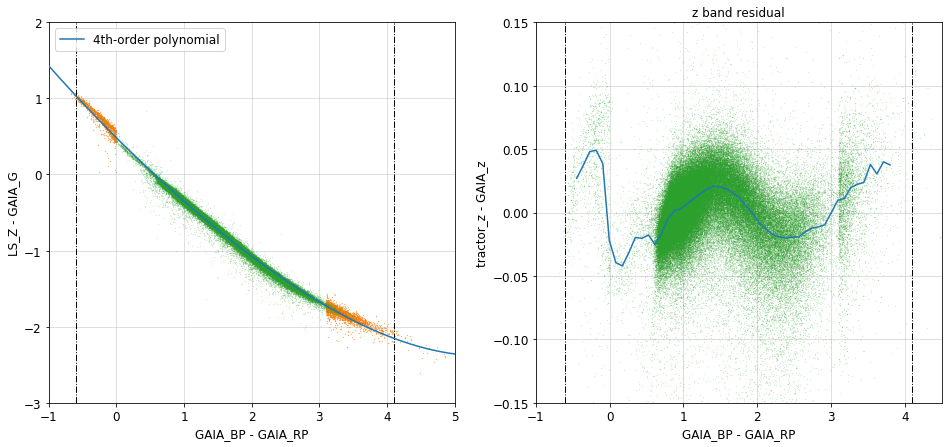

z
[0.4706486791 -0.8581814924 0.0926157841 -0.0684101087 0.0274796491
 -0.0032039775]
[0.4706490000 -0.8581810000 0.0926160000 -0.0684100000 0.0274800000
 -0.0032040000]


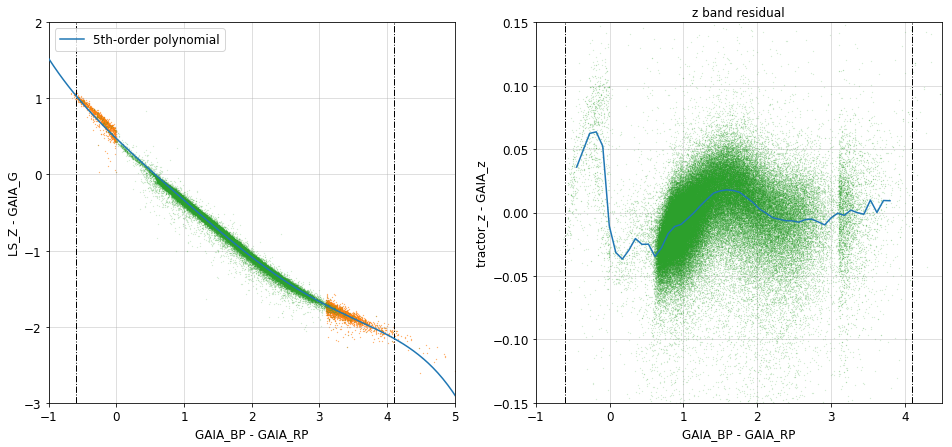

z
[0.4811197807 -0.9291305995 0.0821002381 0.0855148010 -0.0922966813
 0.0303588653 -0.0031982498]
[0.4811200000 -0.9291310000 0.0821000000 0.0855150000 -0.0922970000
 0.0303590000 -0.0031980000]


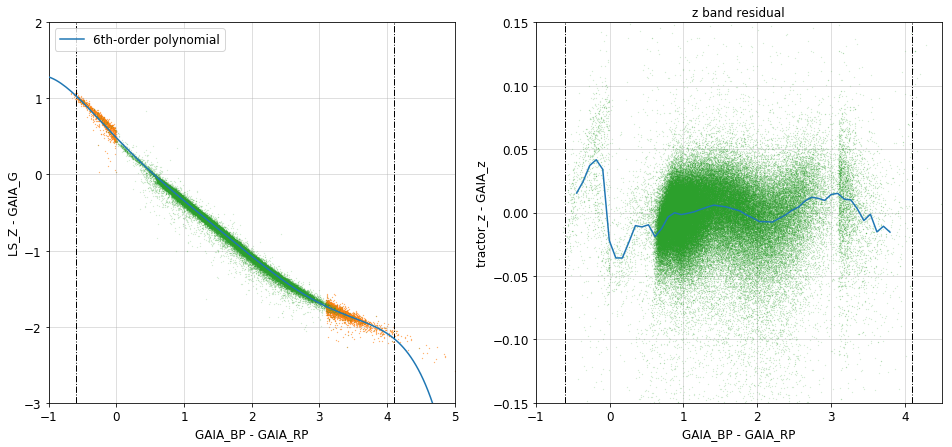

z
[0.4811198057 -0.9990015041 0.1403990019 0.2150988888 -0.2917655866
 0.1326831887 -0.0259205004 0.0018548776]
[0.4811200000 -0.9990020000 0.1403990000 0.2150990000 -0.2917660000
 0.1326830000 -0.0259210000 0.0018550000]


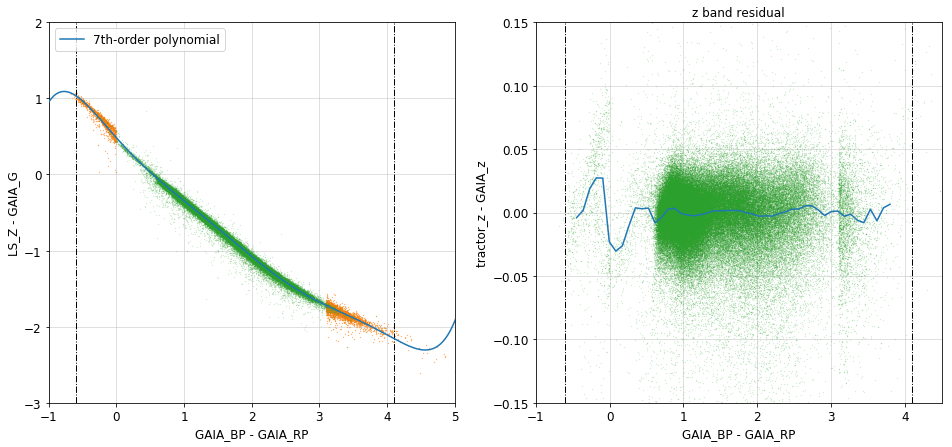

In [107]:
poly_order_list = [4, 5, 6, 7]
for poly_order in poly_order_list:
    
    coeffs_new1 = {}
    x = bprp_list
    y = mag_list
    
    coeffs_new1[band] = rlm_fit1d(x, y, t=1, order=poly_order)
    # coeffs_new[band] = np.polyfit(x, y, deg=2)
    print(band)
    print(coeffs_new1[band])

    coeffs_new1[band] = np.round(coeffs_new1[band], decimals=6)
    print(coeffs_new1[band])

    cat1 = cat.copy()
    extreme1 = extreme.copy()

    gaia_plot1 = Table()
    gaia_plot1['BP_RP'] = np.linspace(-1, 6.2, 200)
    bands = ['z']
    for i, b in enumerate(bands):
        mag = np.zeros(len(gaia_plot1))
        for order, c in enumerate(coeffs_new1[b]):
            mag += c * gaia_plot1['BP_RP']**order
        gaia_plot1['ls_'+b] = mag

    for i, b in enumerate(bands):
        mag = np.copy(cat1['GAIA_PHOT_G_MEAN_MAG'])
        for order, c in enumerate(coeffs_new1[b]):
            mag += c * (cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])**order
        cat1[b+'mag_predict'] = mag

    for i, b in enumerate(bands):
        mag = np.copy(extreme1['GAIA_PHOT_G_MEAN_MAG'])
        for order, c in enumerate(coeffs_new1[b]):
            mag += c * (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])**order
        extreme1[b+'mag_predict'] = mag

    bprp_min, bprp_max = -0.6, 4.1

    mask = np.ones(len(cat1), dtype=bool)
    mask1 = (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG']<0) 
    mask1 |= (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG']>3.1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].plot((cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat1['zmag']-cat1['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
    ax[0].plot((extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])[mask1], (extreme1['zmag']-extreme1['GAIA_PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
    ax[0].plot((gaia_plot1['BP_RP']), (gaia_plot1['ls_z']), '-', label='{}th-order polynomial'.format(poly_order), zorder=3, c='C0')
    ax[0].axvline(bprp_min, lw=1, ls='-.', color='k')
    ax[0].axvline(bprp_max, lw=1, ls='-.', color='k')
    ax[0].set_xlabel('GAIA_BP - GAIA_RP')
    ax[0].set_ylabel('LS_Z - GAIA_G')
    ax[0].axis([-1., 5., -3, 2.])
    ax[0].legend(loc='upper left')
    ax[0].grid(alpha=0.5)
    # ax[0].savefig('plots/decals_z.png')

    x = np.concatenate([(cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])[mask], (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])[mask1]])
    y_tractor = np.concatenate([(cat1[band+'mag'])[mask], (extreme1[band+'mag'])[mask1]])
    y_predict = np.concatenate([(cat1[band+'mag_predict'])[mask], (extreme1[band+'mag_predict'])[mask1]])
    bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)

    ax[1].plot(x, y_tractor-y_predict, 'C2.', ms=0.3, alpha=0.5, zorder=2)
    ax[1].plot(bin_center, bin_median, label='median')
    ax[1].axvline(bprp_min, lw=1, ls='-.', color='k')
    ax[1].axvline(bprp_max, lw=1, ls='-.', color='k')
    ax[1].set_xlabel('GAIA_BP - GAIA_RP')
    ax[1].set_ylabel('tractor_{0} - GAIA_{0}'.format(band))
    ax[1].set_title('{} band residual'.format(band))
    ax[1].axis([-1., 4.5, -0.15, 0.15])
    ax[1].grid(alpha=0.5)
    # ax[1].legend(markerscale=10, loc='upper left')
    plt.savefig('plots/{}-band-{}th-order-polynomial.png'.format(band, poly_order))
    plt.show()

z
[0.4815207585 -0.8871396345 0.0551739839 -0.0017589889 0.0006982034]


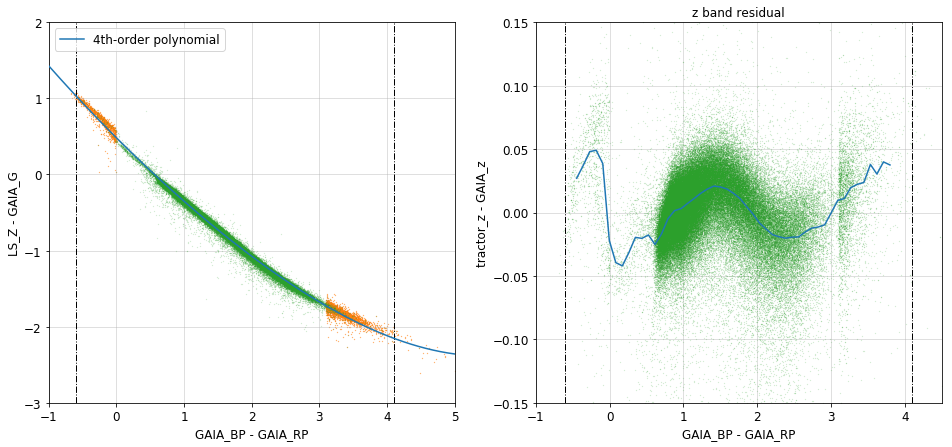

z
[0.4706486791 -0.8581814924 0.0926157841 -0.0684101087 0.0274796491
 -0.0032039775]


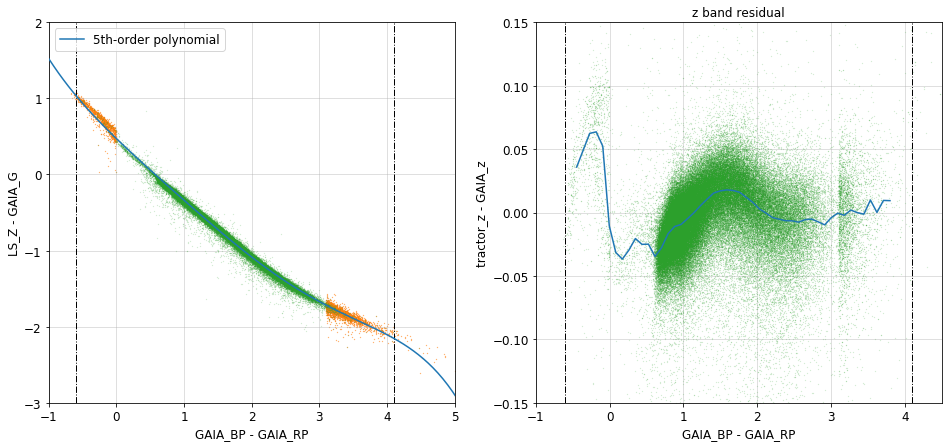

z
[0.4811197807 -0.9291305995 0.0821002381 0.0855148010 -0.0922966813
 0.0303588653 -0.0031982498]


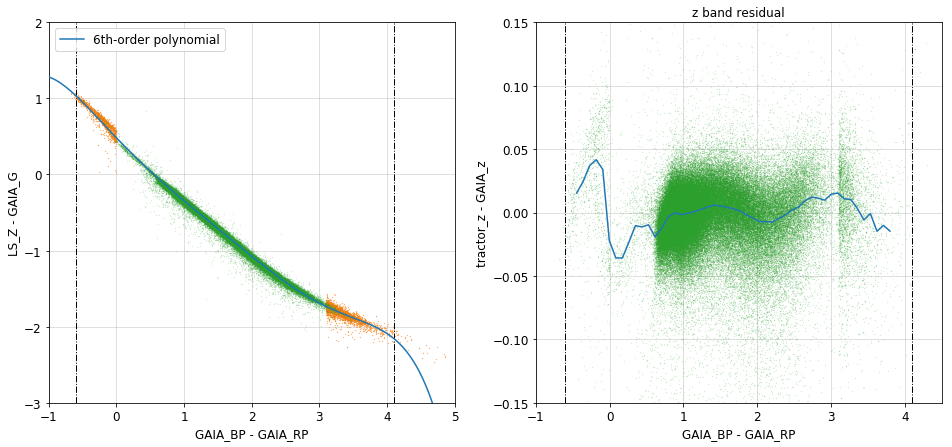

z
[0.4811198057 -0.9990015041 0.1403990019 0.2150988888 -0.2917655866
 0.1326831887 -0.0259205004 0.0018548776]


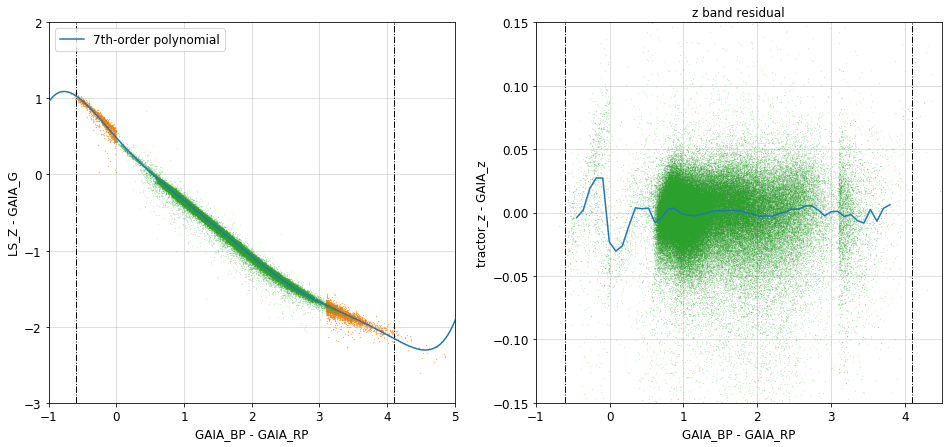

In [108]:
poly_order_list = [4, 5, 6, 7]
for poly_order in poly_order_list:
    
    coeffs_new1 = {}
    x = bprp_list
    y = mag_list
    
    coeffs_new1[band] = rlm_fit1d(x, y, t=1, order=poly_order)
    # coeffs_new[band] = np.polyfit(x, y, deg=2)
    print(band)
    print(coeffs_new1[band])

    # coeffs_new1[band] = np.round(coeffs_new1[band], decimals=6)
    # print(coeffs_new1[band])

    cat1 = cat.copy()
    extreme1 = extreme.copy()

    gaia_plot1 = Table()
    gaia_plot1['BP_RP'] = np.linspace(-1, 6.2, 200)
    bands = ['z']
    for i, b in enumerate(bands):
        mag = np.zeros(len(gaia_plot1))
        for order, c in enumerate(coeffs_new1[b]):
            mag += c * gaia_plot1['BP_RP']**order
        gaia_plot1['ls_'+b] = mag

    for i, b in enumerate(bands):
        mag = np.copy(cat1['GAIA_PHOT_G_MEAN_MAG'])
        for order, c in enumerate(coeffs_new1[b]):
            mag += c * (cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])**order
        cat1[b+'mag_predict'] = mag

    for i, b in enumerate(bands):
        mag = np.copy(extreme1['GAIA_PHOT_G_MEAN_MAG'])
        for order, c in enumerate(coeffs_new1[b]):
            mag += c * (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])**order
        extreme1[b+'mag_predict'] = mag

    bprp_min, bprp_max = -0.6, 4.1

    mask = np.ones(len(cat1), dtype=bool)
    mask1 = (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG']<0) 
    mask1 |= (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG']>3.1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].plot((cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat1['zmag']-cat1['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
    ax[0].plot((extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])[mask1], (extreme1['zmag']-extreme1['GAIA_PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
    ax[0].plot((gaia_plot1['BP_RP']), (gaia_plot1['ls_z']), '-', label='{}th-order polynomial'.format(poly_order), zorder=3, c='C0')
    ax[0].axvline(bprp_min, lw=1, ls='-.', color='k')
    ax[0].axvline(bprp_max, lw=1, ls='-.', color='k')
    ax[0].set_xlabel('GAIA_BP - GAIA_RP')
    ax[0].set_ylabel('LS_Z - GAIA_G')
    ax[0].axis([-1., 5., -3, 2.])
    ax[0].legend(loc='upper left')
    ax[0].grid(alpha=0.5)
    # ax[0].savefig('plots/decals_z.png')

    x = np.concatenate([(cat1['GAIA_PHOT_BP_MEAN_MAG']-cat1['GAIA_PHOT_RP_MEAN_MAG'])[mask], (extreme1['GAIA_PHOT_BP_MEAN_MAG']-extreme1['GAIA_PHOT_RP_MEAN_MAG'])[mask1]])
    y_tractor = np.concatenate([(cat1[band+'mag'])[mask], (extreme1[band+'mag'])[mask1]])
    y_predict = np.concatenate([(cat1[band+'mag_predict'])[mask], (extreme1[band+'mag_predict'])[mask1]])
    bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)

    ax[1].plot(x, y_tractor-y_predict, 'C2.', ms=0.3, alpha=0.5, zorder=2)
    ax[1].plot(bin_center, bin_median, label='median')
    ax[1].axvline(bprp_min, lw=1, ls='-.', color='k')
    ax[1].axvline(bprp_max, lw=1, ls='-.', color='k')
    ax[1].set_xlabel('GAIA_BP - GAIA_RP')
    ax[1].set_ylabel('tractor_{0} - GAIA_{0}'.format(band))
    ax[1].set_title('{} band residual'.format(band))
    ax[1].axis([-1., 4.5, -0.15, 0.15])
    ax[1].grid(alpha=0.5)
    # ax[1].legend(markerscale=10, loc='upper left')
    plt.savefig('plots/{}-band-{}th-order-polynomial-no_rounding.png'.format(band, poly_order))
    plt.show()